Import all the Dependecies

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import (RandomForestRegressor,
                              GradientBoostingRegressor,
                              VotingRegressor, StackingRegressor)

from xgboost import XGBRegressor

from sklearn.feature_selection import mutual_info_regression

import warnings
warnings.filterwarnings("ignore")

Step 1: Importing and Understanding the Dataset

In [9]:
#Import Train Data
train_data = pd.read_csv('../data/train.csv', index_col='Id')
test_data = pd.read_csv('../data/test.csv', index_col='Id')

train_data.shape, test_data.shape


((1460, 80), (1459, 79))

In [10]:
# drop rows with missing target
train_data.dropna(subset=['SalePrice'], inplace=True)

# drop duplicate rows
train_data.drop_duplicates(inplace=True)

train_data.shape, test_data.shape

((1460, 80), (1459, 79))

In [11]:
train_data.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 80, dtype: object

In [12]:


# convert 'MSSubClass' to categorical
train_data['MSSubClass'] = train_data['MSSubClass'].astype('object')
test_data['MSSubClass'] = test_data['MSSubClass'].astype('object')



In [13]:


train_data.columns



Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [14]:
test_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [15]:
missing_count = train_data.isna().sum().sort_values(ascending=False)
cols_with_missing = missing_count[missing_count.values > 0].index
missing_count[missing_count.values > 0]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageType        81
GarageFinish      81
GarageCond        81
GarageYrBlt       81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtFinType1      37
BsmtCond          37
MasVnrArea         8
Electrical         1
dtype: int64

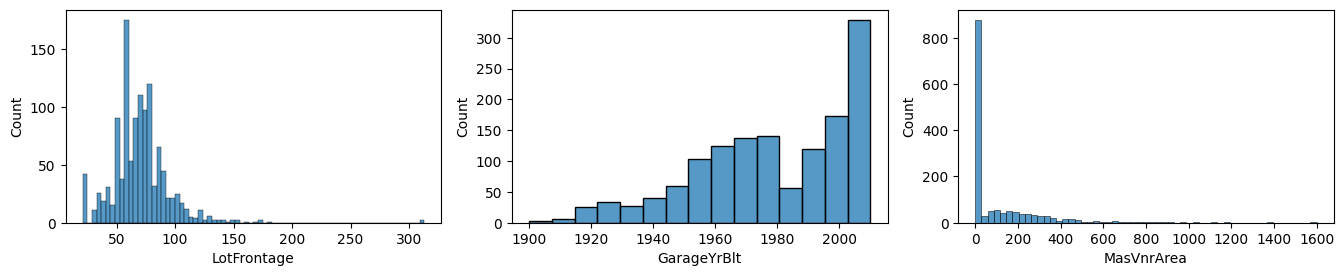

In [16]:


# Basic appraoch: impute numerical features with 0 and categorical with 'NA'.
missing_numerical = train_data[cols_with_missing].select_dtypes(exclude=['object'])

plt.figure(figsize=(18,16))
for i,col in enumerate(missing_numerical.columns):
    plt.subplot(6,4,i+1)
    sns.histplot(train_data[col], kde=False)
plt.tight_layout()



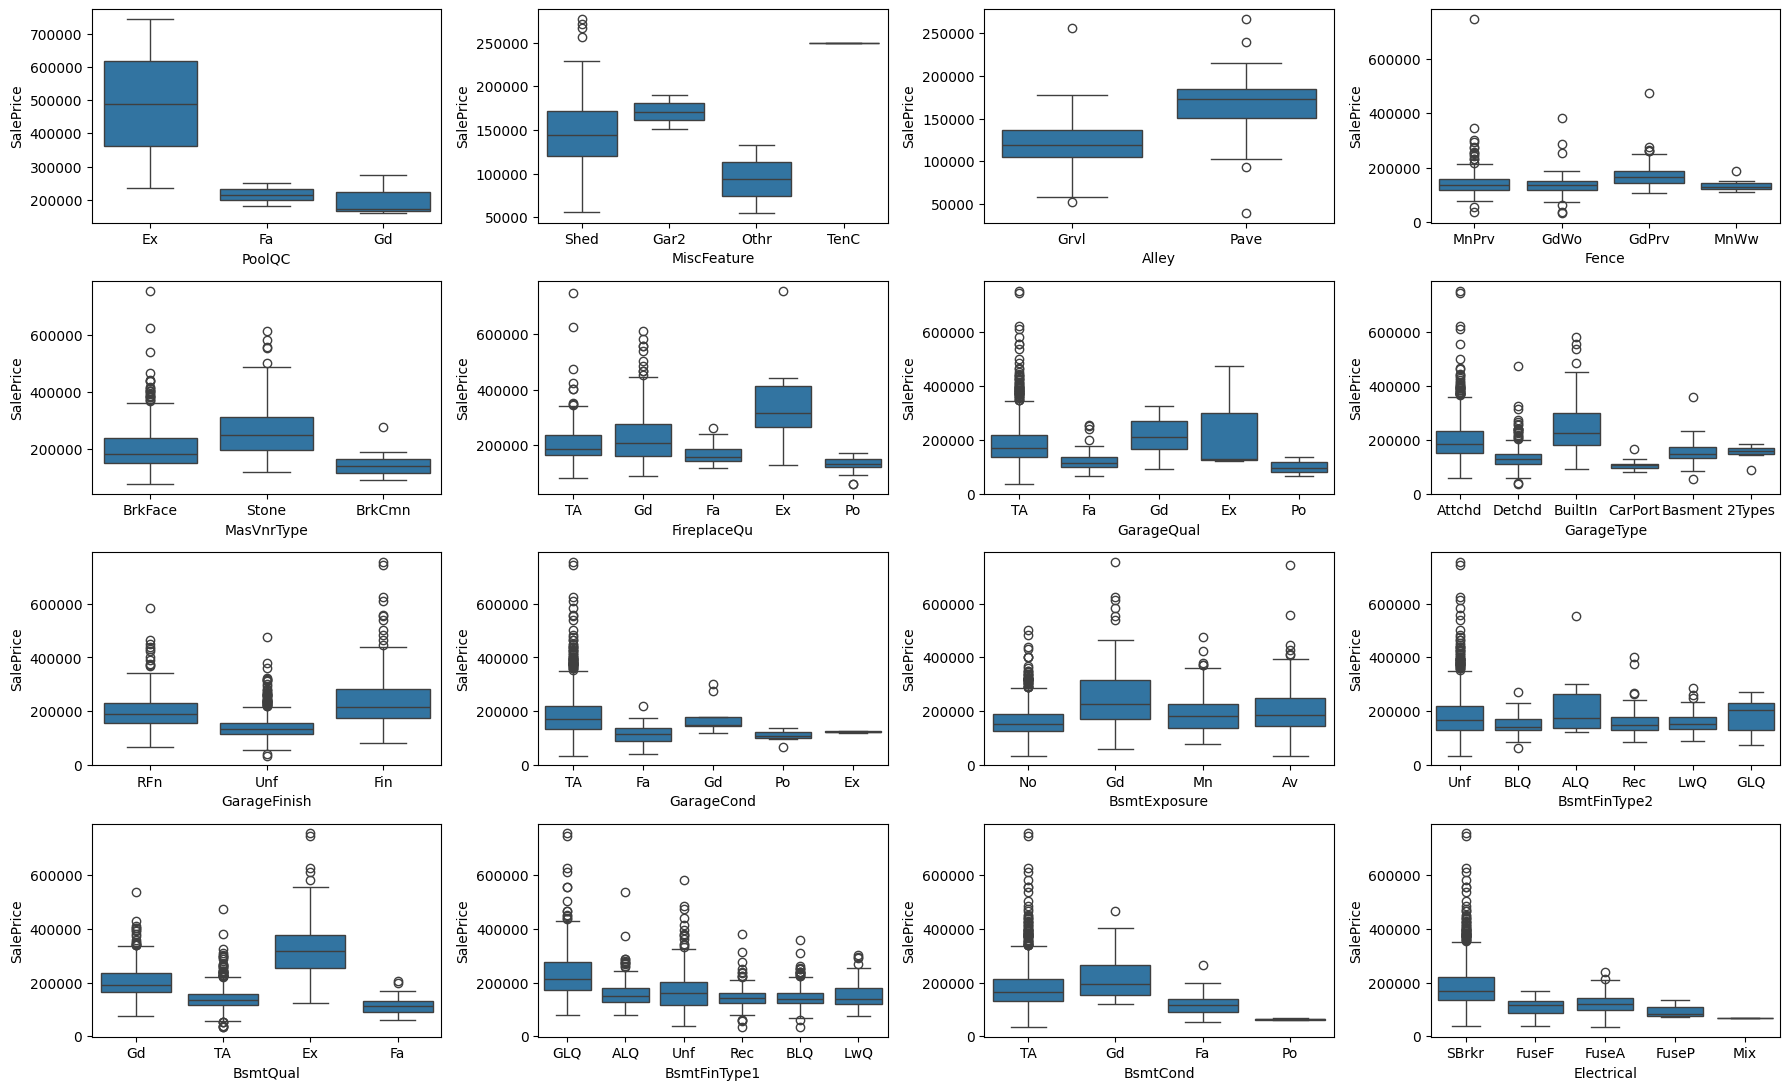

In [17]:


missing_categorical = train_data[cols_with_missing].select_dtypes(include=['object'])

plt.figure(figsize=(18, 16))
for i, col in enumerate(missing_categorical.columns):
    plt.subplot(6, 4, i+1)
    sns.boxplot(x=train_data[col], y=train_data['SalePrice'])
plt.tight_layout()



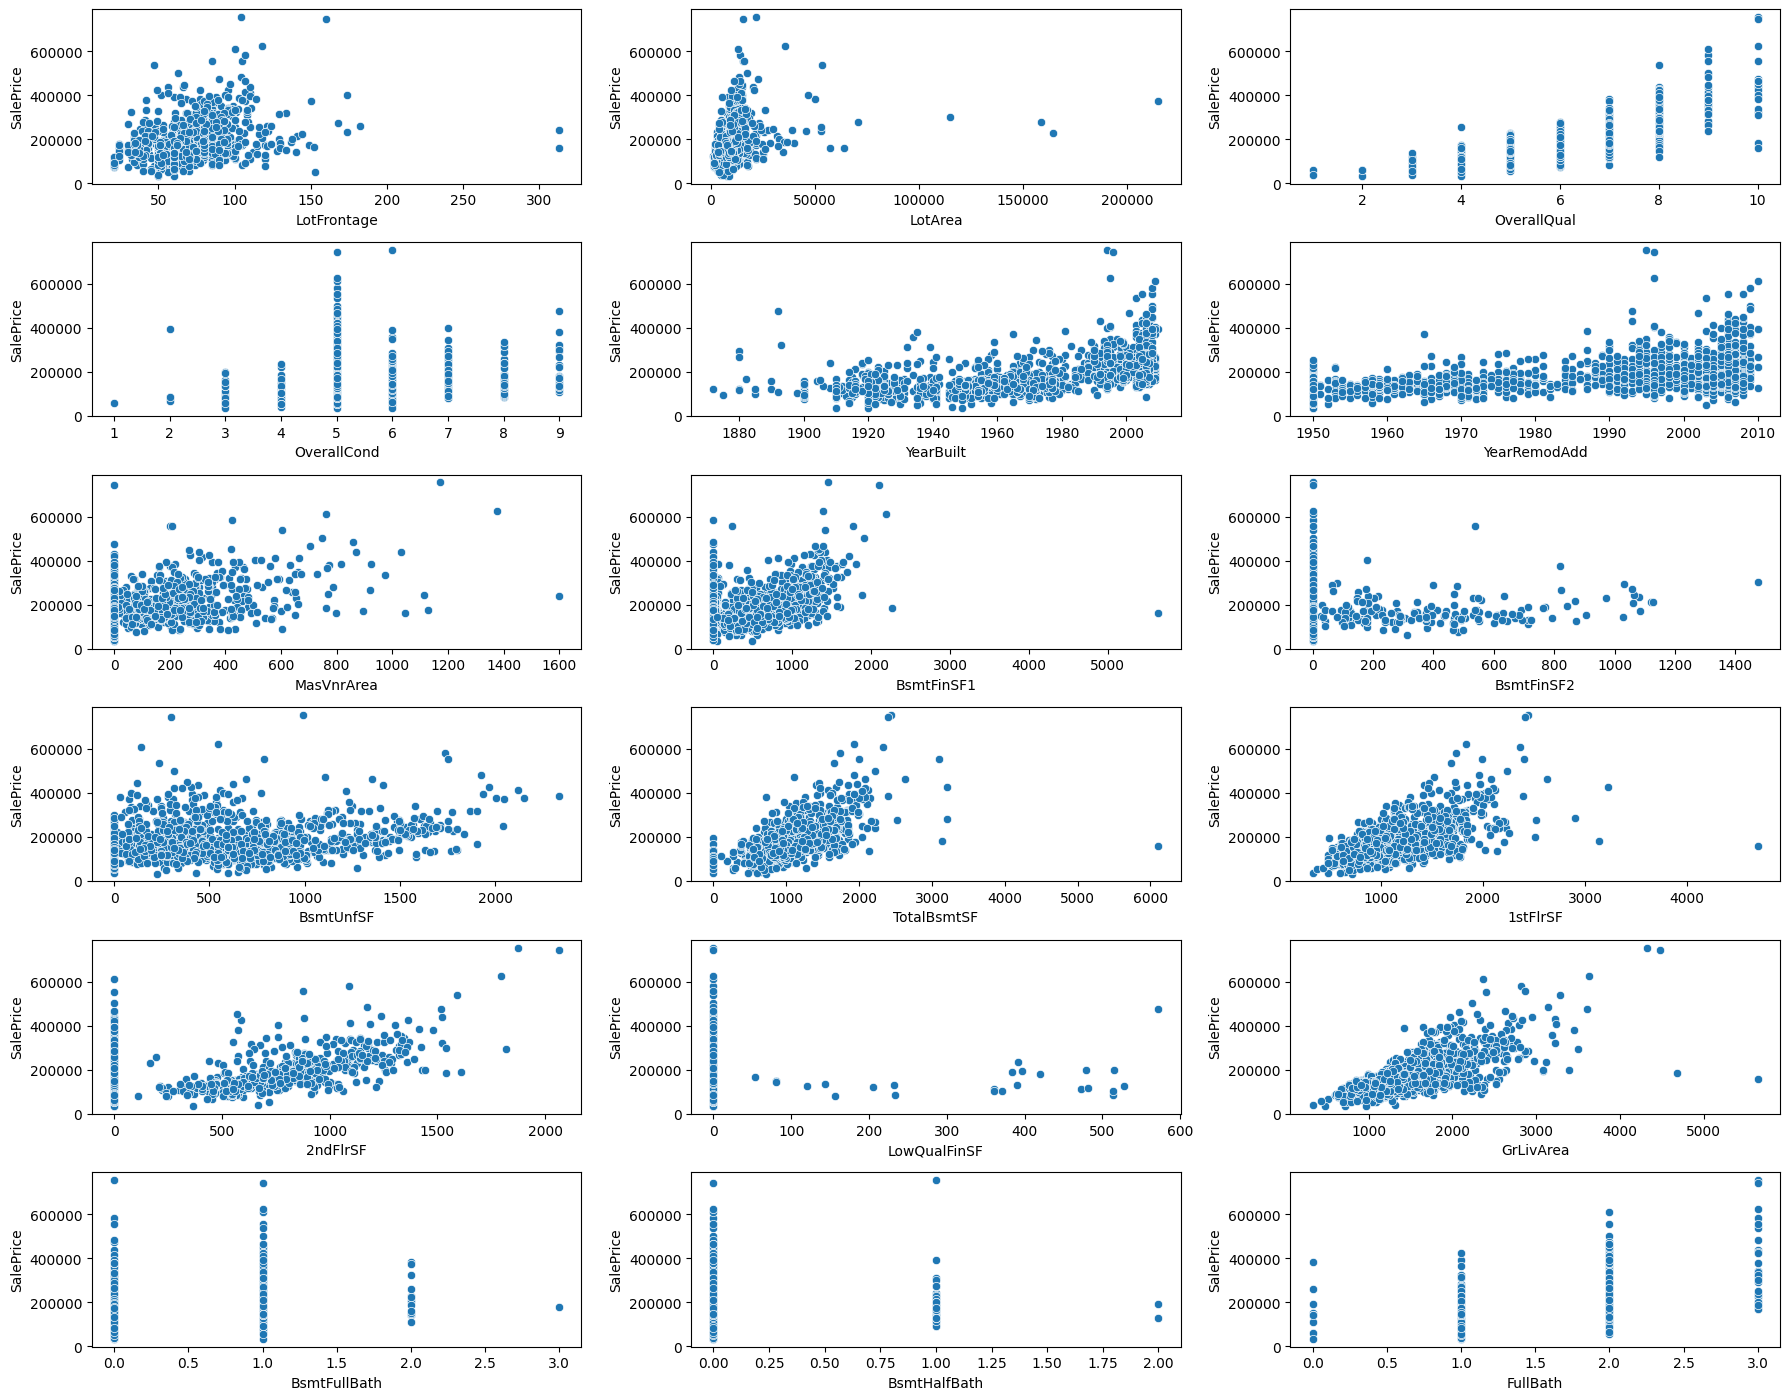

In [18]:


num_columns = train_data.select_dtypes(exclude=['object']).columns

# due to high dimensionality, display only half features here
plt.figure(figsize=(18, 16))
for i, col in enumerate(num_columns[:len(num_columns)//2]):
    plt.subplot(7, 3, i+1)
    sns.scatterplot(x=train_data[col], y=train_data['SalePrice'])
plt.tight_layout()



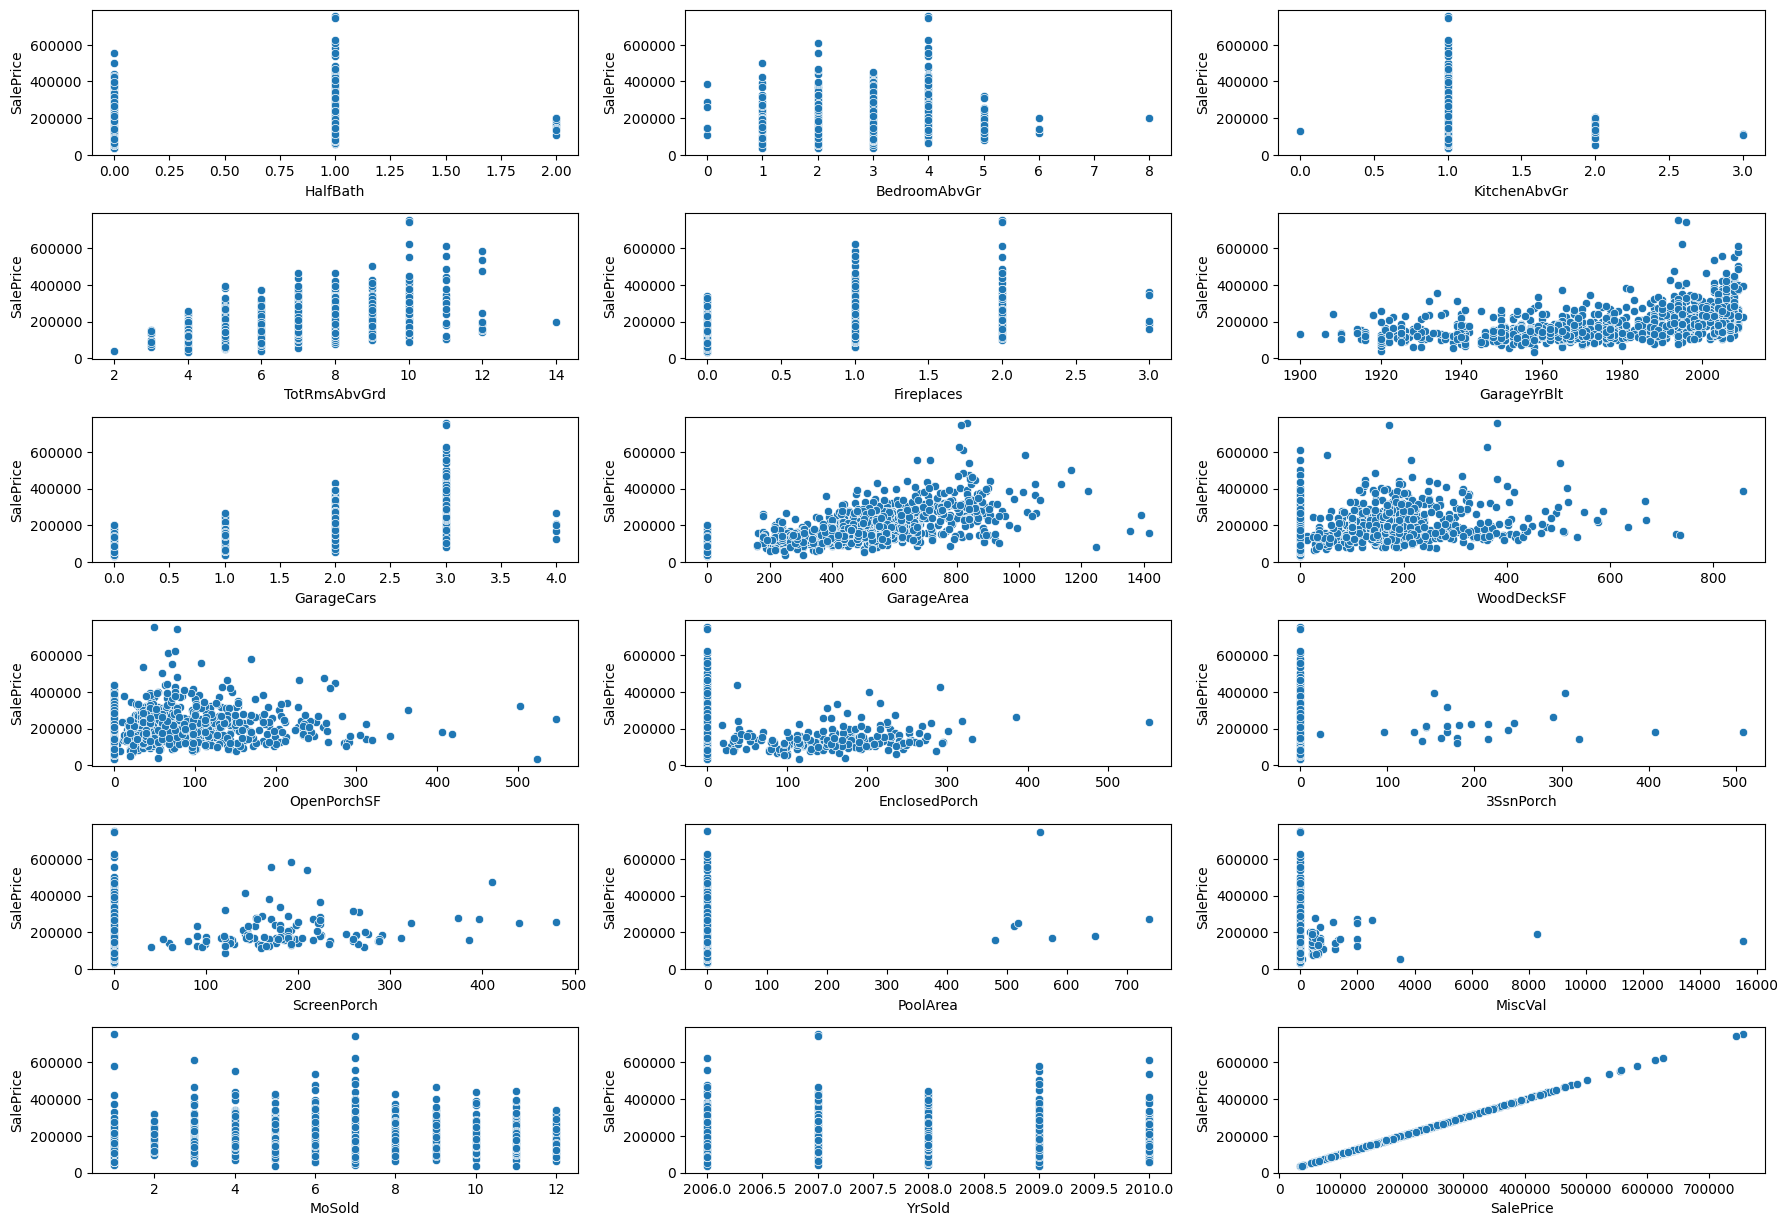

In [19]:
plt.figure(figsize=(18, 16))
for i, col in enumerate(num_columns[len(num_columns)//2:]):
    plt.subplot(8, 3, i+1)
    sns.scatterplot(x=train_data[col], y=train_data['SalePrice'])
plt.tight_layout()

In [20]:
# find and drop outliers
outliers = []

outliers.extend(train_data[train_data['LotFrontage'] > 300].index.tolist())
outliers.extend(train_data[train_data['LotArea'] > 100_000].index.tolist())
outliers.extend(train_data[(train_data['OverallCond'] == 2) & (train_data['SalePrice'] > 200_000)].index.tolist())
outliers.extend(train_data[(train_data['OverallCond'] == 6) & (train_data['SalePrice'] > 600_000)].index.tolist())
outliers.extend(train_data[train_data['MasVnrArea'] > 1500].index.tolist())
outliers.extend(train_data[train_data['BsmtFinSF1'] > 5000].index.tolist())
outliers.extend(train_data[train_data['BsmtFinSF2'] > 1400].index.tolist())
outliers.extend(train_data[train_data['TotalBsmtSF'] > 6000].index.tolist())
outliers.extend(train_data[train_data['1stFlrSF'] > 4000].index.tolist())
outliers.extend(train_data[train_data['GrLivArea'] > 4500].index.tolist())

outliers = set(outliers)
train_data = train_data.drop(outliers)

<Axes: >

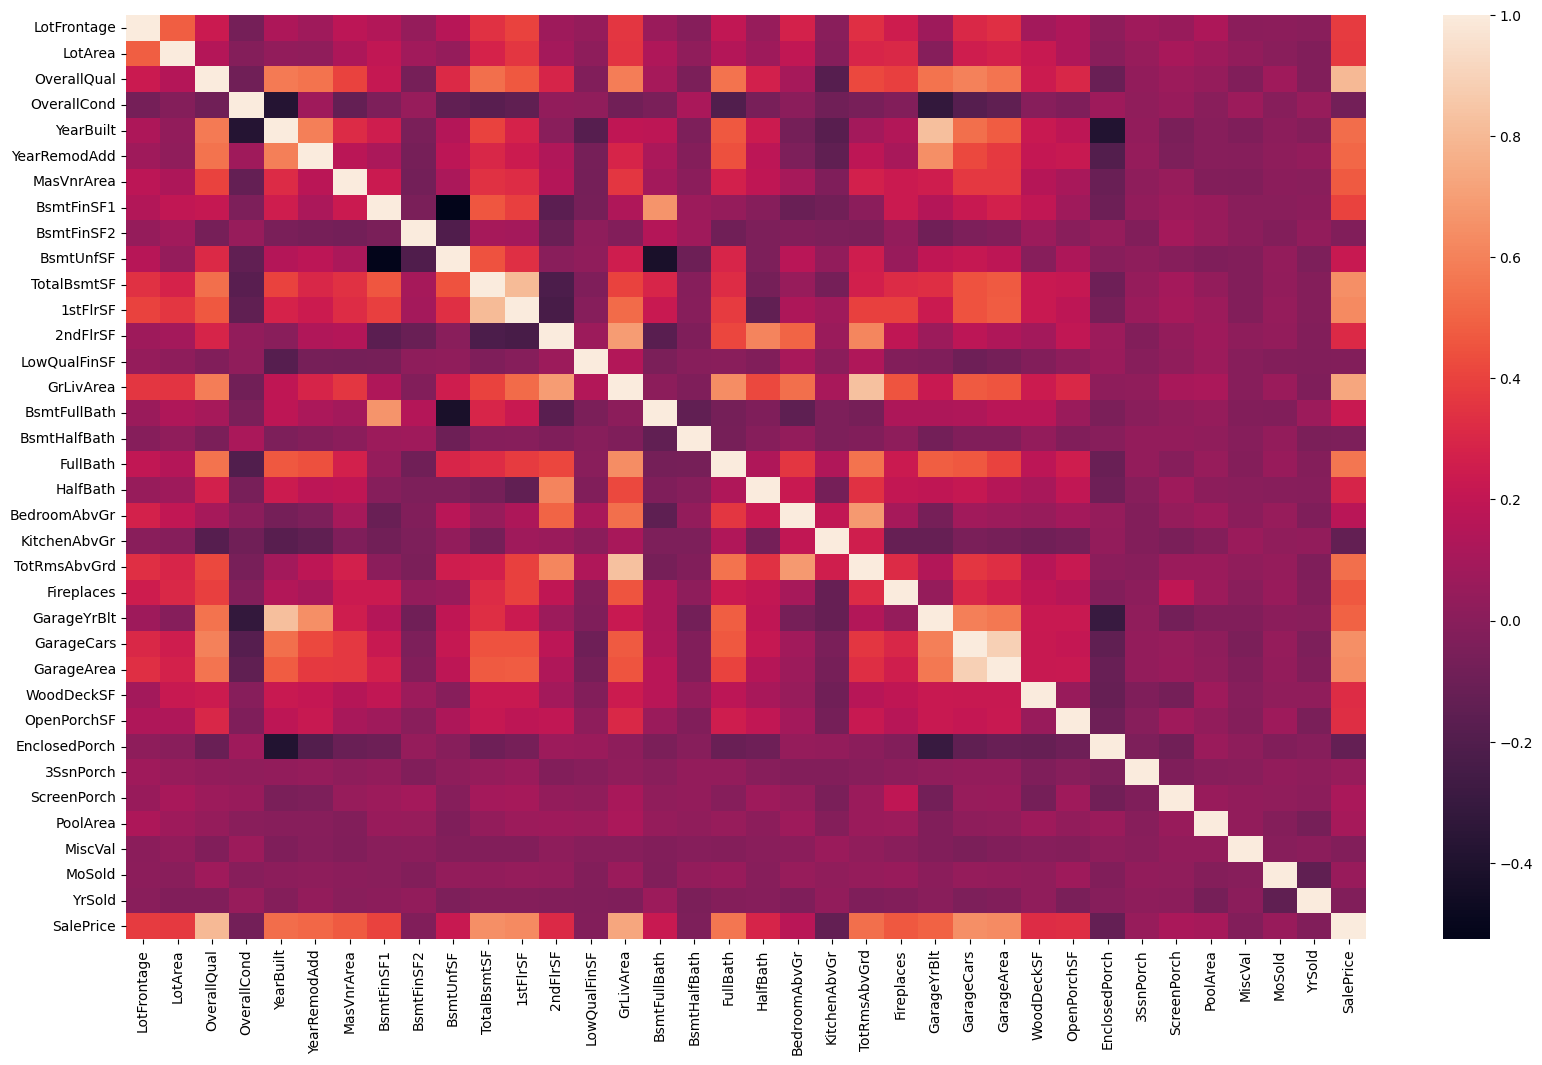

In [21]:
plt.figure(figsize=(20, 12))
sns.heatmap(train_data.select_dtypes(exclude=['object']).corr())

In [22]:
train_data['TotalLotArea'] = train_data['LotFrontage'] + train_data['LotArea']
test_data['TotalLotArea'] = test_data['LotFrontage'] + test_data['LotArea']

train_data['TotalPorchSF'] = train_data['OpenPorchSF'] + train_data['EnclosedPorch'] + \
                             train_data['3SsnPorch']+ train_data['ScreenPorch']
test_data['TotalPorchSF'] = test_data['OpenPorchSF'] + test_data['EnclosedPorch'] + \
                             test_data['3SsnPorch']+ test_data['ScreenPorch']

train_data['Bathrooms'] = train_data['FullBath'] + train_data['BsmtFullBath'] + \
                          0.5 * (train_data['HalfBath'] + train_data['BsmtHalfBath'])

test_data['Bathrooms'] = test_data['FullBath'] + test_data['BsmtFullBath'] + \
                          0.5 * (test_data['HalfBath'] + test_data['BsmtHalfBath'])


In [23]:
columns_to_drop = ['LotFrontage', 'LotArea', 'OpenPorchSF', 'EnclosedPorch',
                   '3SsnPorch', 'ScreenPorch', 'FullBath', 'HalfBath',
                   'BsmtFullBath', 'BsmtHalfBath']

columns_to_drop.extend(['GarageYrBlt', 'TotRmsAbvGrd', 'GarageArea', '1stFlrSF', '2ndFlrSF'])

train_data = train_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)

<Axes: >

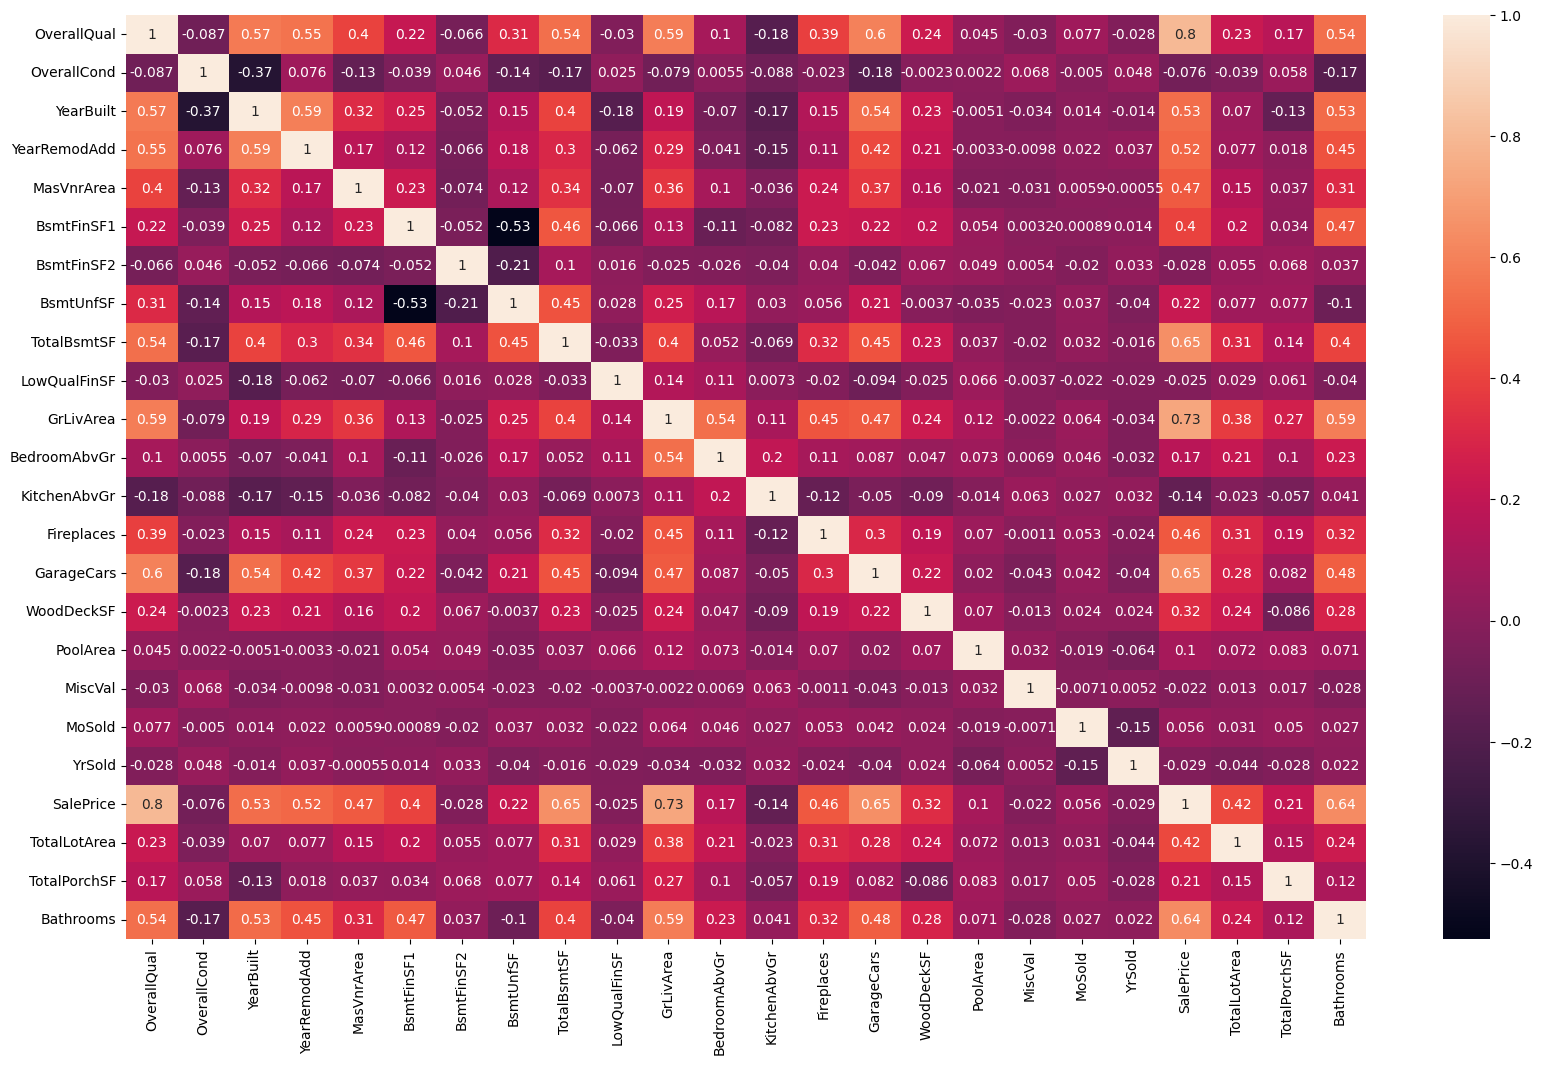

In [24]:
plt.figure(figsize=(20, 12))
sns.heatmap(train_data.select_dtypes(exclude=['object']).corr(), annot=True)

In [25]:


# split training data into features and target
X = train_data.drop(['SalePrice'], axis=1)
y = np.log(train_data['SalePrice'])

X.shape, y.shape



((1449, 67), (1449,))

In [26]:
num_columns = X.select_dtypes(exclude=['object']).columns

# split categorical features into ordinal and nominal
ord_columns = ['LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
              'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional',
              'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'PavedDrive']
ord_columns = [col for col in ord_columns if col in X.columns] # in case we dropped some of these hardcoded features

ohe_columns = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'Utilities',
               'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
               'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
               'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical',
               'GarageType', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
ohe_columns = [col for col in ohe_columns if col in X.columns]

In [27]:
class DataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.num_cols = None
        self.cat_ohe_cols = None
        self.cat_ord_cols = None
        self.cat_cols = None

        self.num_imputer = SimpleImputer(strategy='mean')
        self.cat_imputer = SimpleImputer(strategy='constant', fill_value='NA')

        self.scaler = StandardScaler()
        self.ohe_encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
        self.ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        
    def fit(self, X, y=None):
        self.num_cols = X.select_dtypes(exclude=['object']).columns
        self.cat_ohe_cols = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'Utilities',
                             'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
                             'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
                             'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical',
                             'GarageType', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
        self.cat_ord_cols = ['LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual',
                             'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                             'HeatingQC', 'KitchenQual', 'Functional','FireplaceQu',
                             'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'PavedDrive']

        self.cat_cols = self.cat_ohe_cols + self.cat_ord_cols

        # fit imputers
        self.num_imputer.fit(X[self.num_cols])
        self.cat_imputer.fit(X[self.cat_cols])

        # fit scaler and encoders
        self.scaler.fit(X[self.num_cols])
        self.ohe_encoder.fit(X[self.cat_ohe_cols])
        self.ord_encoder.fit(X[self.cat_ord_cols])
        
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        # Apply imputers
        X_copy[self.num_cols] = self.num_imputer.transform(X_copy[self.num_cols])
        X_copy[self.cat_cols] = self.cat_imputer.transform(X_copy[self.cat_cols])

        # Scale numerical features
        X_scaled = self.scaler.transform(X_copy[self.num_cols])
        X_scaled_df = pd.DataFrame(X_scaled, columns=self.num_cols, index=X.index)

        # Encode categorical features (one hot encoding)
        X_encoded_ohe = pd.DataFrame(self.ohe_encoder.transform(X_copy[self.cat_ohe_cols]))
        X_encoded_ohe.index = X_copy.index
        X_encoded_ohe.columns = self.ohe_encoder.get_feature_names_out()

        # Encode categorical features (ordinal encoding)
        X_encoded_ord = pd.DataFrame(self.ord_encoder.transform(X_copy[self.cat_ord_cols]))
        X_encoded_ord.index = X_copy.index
        X_encoded_ord.columns = self.ord_encoder.get_feature_names_out()

        # Combine all processed features
        X_final = pd.concat([X_scaled_df, X_encoded_ohe, X_encoded_ord], axis=1)
        return X_final

In [28]:
class FeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns_to_keep = None
        
    def fit(self, X, y=None):
        mi_scores = self.make_mi_scores(X, y)
        self.columns_to_keep = X.loc[:, mi_scores > 0.0].columns
        return self

    def transform(self, X):
        return X[self.columns_to_keep]

    def make_mi_scores(self, X, y):
        X = X.copy()
        mi_scores = mutual_info_regression(X, y, random_state=0)
        mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
        mi_scores = mi_scores.sort_values(ascending=False)
        return mi_scores

In [29]:
preprocessor = Pipeline(steps=[
    ('preprocessor', DataPreprocessor()),
    # ('feature selection', FeatureSelection())
])

p = preprocessor.fit_transform(X, y).shape[1]

In [30]:
def find_best_params(model, parameters, X, y, preprocessor, cv=5,
                     scoring='neg_root_mean_squared_error'):
    X_processed = preprocessor.fit_transform(X, y) 
    grid_search = GridSearchCV(model, parameters, cv=cv, scoring=scoring, verbose=1)
    grid_search.fit(X_processed, y)
    return grid_search.best_params_

def adjusted_r2(r2, n, p):
    return 1 - (1 - r2)*(n-1) / (n-p-1)

def cross_validate_scores(pipeline, X, y, n_splits=5,
                          scoring=('r2', 'neg_root_mean_squared_error'), random_state=123):
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    cv_scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, return_train_score=True)
    
    cv_scores['train_root_mean_squared_error'] = -cv_scores['train_neg_root_mean_squared_error']
    cv_scores['test_root_mean_squared_error'] = -cv_scores['test_neg_root_mean_squared_error']
    
    n = X.shape[0]
    cv_scores['train_r2_adj'] = [adjusted_r2(r2, n, p) for r2 in cv_scores['train_r2']]
    cv_scores['test_r2_adj'] = [adjusted_r2(r2, n, p) for r2 in cv_scores['test_r2']]
    
    return {'train_r2': np.mean(cv_scores['train_r2']),
            'train_r2_adj': np.mean(cv_scores['train_r2_adj']),
            'train_rmse': np.mean(-cv_scores['train_neg_root_mean_squared_error']),
            'test_r2': np.mean(cv_scores['test_r2']),
            'test_r2_adj': np.mean(cv_scores['test_r2_adj']),
            'test_rmse': np.mean(-cv_scores['test_neg_root_mean_squared_error'])}

In [31]:
parameters = {'alpha': [0.5, 1, 5, 10, 15, 20], 'max_iter': [None, 100, 200]}

best_params = find_best_params(Ridge(), parameters, X, y, preprocessor)
print(f'Best parameters: {best_params}')

pipeline_ridge = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', Ridge(**best_params))
])

model_cv_scores = {}
model_cv_scores["Ridge"] = cross_validate_scores(pipeline_ridge, X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'alpha': 15, 'max_iter': None}


In [32]:
best_params = {'C': 0.1, 'epsilon': 0.005, 'kernel': 'linear'} # skip grid search to reduce computation time
print(f'Best parameters: {best_params}')

pipeline_svr = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', SVR(**best_params))
])

model_cv_scores["SVR"] = cross_validate_scores(pipeline_svr, X, y)

Best parameters: {'C': 0.1, 'epsilon': 0.005, 'kernel': 'linear'}


In [33]:
best_params = {'learning_rate': 0.1, 'loss': 'huber', 'n_estimators': 150} # skip grid search to reduce computation time
print(f'Best parameters: {best_params}')

pipeline_gr_boost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(**best_params))
])

model_cv_scores['GradientBoostingRegressor'] = cross_validate_scores(pipeline_gr_boost, X, y)

Best parameters: {'learning_rate': 0.1, 'loss': 'huber', 'n_estimators': 150}


Step 2 : Data Preprocessing

In [34]:
model_cv_scores_df = pd.DataFrame.from_dict(model_cv_scores, orient='index')
model_cv_scores_df.reset_index(inplace=True)
model_cv_scores_df.rename(columns={'index': 'Model'}, inplace=True)
model_cv_scores_df

,Model,train_r2,train_r2_adj,train_rmse,test_r2,test_r2_adj,test_rmse
0,Ridge,0.935146,0.924390,0.100912,0.917726,0.904080,0.113031
1,SVR,0.934899,0.924102,0.101108,0.913996,0.899731,0.115575
2,GradientBoostingRegressor,0.959280,0.952526,0.079960,0.902882,0.886773,0.123128


In [35]:
pipeline_voting_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', VotingRegressor(estimators=[
        ('gb', pipeline_gr_boost['model']),
        ('ridge', pipeline_ridge['model']),
        ('svr', pipeline_svr['model'])
    ], weights=None, n_jobs=-1))
])

stacking_cv_scores = {}
stacking_cv_scores['VotingRegressor'] = cross_validate_scores(pipeline_voting_reg, X, y)

In [36]:
estimators = [('vr', pipeline_voting_reg['model']),
              ('gb', pipeline_gr_boost['model']),
              ('ridge', pipeline_ridge['model']),
              ('svr', pipeline_svr['model'])]

# a simple model is usually enough to be used as meta-estimator
final_estimator = Ridge()

pipeline_stacked_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', StackingRegressor(
                estimators=estimators,
                final_estimator=final_estimator,
                n_jobs=-1))
])

stacking_cv_scores['StackingRegressor'] = cross_validate_scores(pipeline_stacked_reg, X, y)

In [37]:
stacking_cv_scores_df = pd.DataFrame.from_dict(stacking_cv_scores, orient='index')
stacking_cv_scores_df.reset_index(inplace=True)
stacking_cv_scores_df.rename(columns={'index': 'Model'}, inplace=True)
stacking_cv_scores_df

,Model,train_r2,train_r2_adj,train_rmse,test_r2,test_r2_adj,test_rmse
0,VotingRegressor,0.949222,0.940800,0.089297,0.920958,0.907848,0.110732
1,StackingRegressor,0.949980,0.941683,0.088622,0.921114,0.908029,0.110636


In [38]:
pipeline_stacked_reg.fit(X, y)

test_pred = np.exp(pipeline_stacked_reg.predict(test_data))
predictions = pd.DataFrame({'Id': test_data.index, 'SalePrice': test_pred})
predictions.to_csv('finalsubmission.csv', index=False)